<a href="https://colab.research.google.com/github/solozano0725/diplomadoMLNivel1/blob/main/DipMLsesion14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="140px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="10px" vspace="0px"></p>

# **Diplomado de Análisis de datos y Machine Learning en Python**


El presente diplomado hace parte del centro de Big Data de la facultad de ciencias exactas y naturales (FCEN) de la Universidad de Antioquia.

## **Sesión 14**

## **Contenido**

- <a href="#pip"> Pipelines</a><br>
- <a href="#val"> Validación cruzada</a><br>
- <a href="#int"> Interacción de características</a><br>



In [ ]:
e

<p><a name="pip"></a></p>

# **Pipelines**

Hemos visto cómo la construcción de un sistema de ML requiere de diferentes etapas: preprocesado de los datos, construcción del modelo y su posterior evaluación. También vimos cómo esta etapa de preprocesado afecta directamente los resultados que obtenemos del modelo final.

Un *Pipeline* permite encadenar estas etapas secuencialmente. 


<p><img alt="Colaboratory logo" height="340px" src="https://i.imgur.com/Q5C8NGb.png" align="left" hspace="10px" vspace="0px"></p>

Específicamente, un Pipeline es un objeto que agrupa las etapas de preprocesamiento y modelado como si tratara de un solo paso, de manera que podamos automatizar todo el proceso manteniendo el código de preprocesamiento y de modelado de una forma muy organizada.

Las dos principales ventajas de trabajar con pipelines son las siguientes:

* Normalmente necesitaremos realizar un seguimiento como tal de los datos de entrenamiento y prueba en cada uno de los pasos de preprocesado, modelado y evaluación, lo que supone una tarea muy complicada desde el punto de vista de la implementación. Con los *pipelines* no necesitaremos de este seguimiento y tendremos un código mucho más simple y limpio.

* Con los pipelines, vamos a poder evaluar todo el proceso, que incluye las etapas de preprocemiento y de construcción del modelo, como un todo. Más que evaluar solo el modelo final, como lo veníamos haciendo.

Volvamos al problema en el que hemos estado trabajando:

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/diplomadomludea/nivel_1/master/data/FuelConsumption.csv").drop(columns="MODELYEAR")
df.head()

,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [ ]:
# matriz de caracteristicas
X = df.drop(columns=["CO2EMISSIONS"])

# variable objetivo
y = df[["CO2EMISSIONS"]]

El *pipeline* aplica secuencialmente una lista de transformadores y un estimador final. Los pasos intermedios del *pipeline* deben ser 'transformaciones', es decir, deben implementar los métodos `fit` y `transform`. El estimador final solo necesita implementar el método `fit`. 

Podemos utilizar la clase ` make_pipeline`, la cual es un alias de la clase `pipeline` en la que no tenemos que hacer explícito el nombre del transformador/estimador, simplemente pasar los transformadores/estimadores que queramos encadenar

In [ ]:
from sklearn.pipeline import make_pipeline

Comencemos con las transformaciones de las variables numéricas

In [ ]:
num_imputer = SimpleImputer(strategy="mean")
scale = StandardScaler()

num_trans = make_pipeline(num_imputer, scale)
num_trans

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

las transformaciones de las variables categóricas:

In [ ]:
cat_imputer = SimpleImputer(strategy="most_frequent")
ohe = OneHotEncoder(drop="first")

cat_trans = make_pipeline(cat_imputer, ohe)
cat_trans

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(categories='auto', drop='first',
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='error', sparse=True))],
         verbose=False)

Ahora, vamos a querer aplicar estas transformaciones que hemos definido a nuestro conjunto de datos. En principio podríamos seleccionar las caracteristicas numéricas y categóricas y aplicar la transformación correspondiente a cada una de estas y al final combinar ambas características transformadas en un solo conjunto de datos, pero este es justamente el proceso que queremos evitar, recordemos que queremos tener todo el proceso automatizado, de manera que no nos tengamos que preocupar por este tipo de pasos. 

Entonces Lo que haremos será utilizar un transformador de columnas `ColumnTransformer` (o `make_column_transformer`), de manera que construyamos un único objeto que realice estas tareas de preprocesamiento de una forma más simple y automática.   

Debemos pasar tuplas de la forma `(transformador, columnas)` para específicar las transformaciones que queremos aplicar a cada variable:

In [ ]:
from sklearn.compose import make_column_transformer

num_features = ["ENGINESIZE","FUELCONSUMPTION_CITY"]
cat_features = ["MAKE","VEHICLECLASS","TRANSMISSION","FUELTYPE"]

preprocessor = make_column_transformer((num_trans, num_features), 
                                       (cat_trans, cat_features))

Ahora que tenemos el proceso de transformación de los datos en este objeto, nos resta añadir el paso de construcción del modelo de manera que tengamos todo el proceso en un solo objeto. Para esto, de nuevo, utilizaremos un Pipeline que nos encadene el preprocesado con las construcción del modelo de regresión lineal:

In [ ]:
LR = LinearRegression()

model = make_pipeline(preprocessor, LR)
model

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                             

Una vez tenemos todo el proceso en este único objeto, podemos entrenar el modelo y evaluar todo el proceso como un todo:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# entrenamiento
model.fit(X_train, y_train)

# evaluacion
model.score(X_test, y_test)

0.9858736959340231

Ahora, si queremos acceder a los atributos `coef_` o `intercept_` de la regresión lineal, como esta está embebida en un pipeline, debemos utilizar el nombre del estimador como clave (que con `make_pipeline` se hace de forma automática) para acceder a esta información:

In [ ]:
model["linearregression"].coef_

array([[   2.64809976,   70.18635528,   11.76900832,    7.70026555,
           7.95019479,    2.15884438,    4.29708852,    4.04757869,
           1.04803438,    5.47884484,    2.36473645,    6.60286307,
           8.62542242,   -0.29251127,    1.90461498,    6.52232135,
           4.78193208,    7.16414117,    8.02881955,    7.03687382,
          -3.81449782,    5.55308354,    8.26281454,    8.19546227,
           5.36182527,    3.73209848,    8.34000742,    5.99706579,
           3.12051605,    7.67271641,    3.79575565,    3.53592   ,
           3.59377065,    6.20346534,   -1.07969   ,    7.72989025,
           7.13314698,    8.14153268,    4.14246141,    6.78125682,
          -2.29433797,   -1.97628462,   -1.31275607,    4.59615589,
          11.19085866,   13.00851864,    3.1414074 ,   -1.35541076,
           0.61948819,   -2.96310093,    5.89592599,    9.32594702,
          -2.47837733,   14.06321838,   10.37342014,   -4.67553076,
          -7.05155271,   -8.19886541,   -7.84965

In [ ]:
model["linearregression"].intercept_

array([290.68355483])

Note que si queremos modificar algo en el proceso de construcción del sistema, ya sea en la etapa de preprocesado o de modelamiento, simplemente modificamos los transformadores o estimadores, y el pipeline se encargará de hacer todo por nosotros. 

<p><a name="val"></a></p>

# **Validación cruzada**

Hasta el momento la estrategia que hemos seguido para la evaluación de los modelos supervisados se basa en la separación del conjunto de datos en subconjuntos de entrenamiento y prueba. Esta estrategia se conoce como *hold-out set*





**hold-out set**

![picture](https://www.researchgate.net/profile/Brian_Mwandau/publication/325870973/figure/fig6/AS:639531594285060@1529487622235/Train-Test-Data-Split.png)

Una desventaja de utilizar esta estrategia es que perdemos una porcion de los datos para el entrenamiento del modelo, lo cual es particularmente problematico si el conjunto de datos es pequeño. 

Recordemos que la razón por la que dividimos nuestros datos en los subconjuntos de entrenamiento y prueba es porque estamos interesados en medir qué tan bien nuestro modelo se generaliza a nuevos datos. Es decir, no nos interesa saber qué tan bien se ajusta nuestro modelo a los datos de entrenamiento, sino más bien qué tan bien puede hacer predicciones para datos que no se observaron durante el proceso de entrenamiento.

Ccuando utilizamos la función `train_test_split` especificamos el parámetro `random_state` que define qué instancias se utilizarán para el entrenamiento y para la prueba. Como ya hemos experimentado, si cambiamos el valor de este parámetro generalmente habrá un cambio en el rendimiento del modelo, ya que estos suelen ser susceptibles a una variación en los datos de entrada. Esto supone entonces que si solo utilizamos una porción de los datos para el entrenamiento del modelo, no podremos tener evidencia concluyente sobre la precisión del modelo.

Una forma de resolver estos problemas es usando lo que se conoce como **validación cruzada**. La validación cruzada es un método estadístico para evaluar el rendimiento de generalización de un modelo que es más estable y completo, particularmente útil en el caso de conjuntos de datos pequeños. En la validación cruzada, se utilizan diferentes subconjuntos de los datos de forma iterativa tanto para el entrenamiento como para la prueba. 

Existen diferentes formas de validación cruzada. La más común es la validación cruzada de *k folds*.

La siguiente imagen es un ejemplo de una validacion cruzada de 5 folds: los datos se dividen en cinco subconjuntos de aproximadamente el mismo tamaño, con los que se procede a entrenar una secuencia de 5 modelos



**k-fold cross validation**

![picture](https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/233459a6-523d-4cf7-91f3-ff539a1b58ce/f6c9980c-ed0d-4564-8289-e95c9274b48e/images/screenshot.png)



Al final, habremos obtenido cinco puntajes de validación para nuestro modelo. Cada instancia del conjunto de datos estará en el conjunto de entrenamiento exactamente una vez.

Es importante tener en cuenta que la validación cruzada no es una forma de construir un modelo que pueda aplicarse a nuevos datos. La validación cruzada no devuelve un modelo sino que crea múltiples modelos internamente con el propósito de evaluar qué tan bien se generalizará un modelo dado cuando se entrene en un conjunto de datos específico. 

Veamos este proceso explícitamente con 2 folds:


In [ ]:
X = df[["ENGINESIZE","FUELCONSUMPTION_CITY"]]

X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=42)

LR = LinearRegression()

In [ ]:
LR.fit(X1, y1).score(X2, y2)

0.8612149544010091

In [ ]:
LR.fit(X2, y2).score(X1, y1)

0.8555962448041052

La validación cruzada se implementa en Sklearn con la función `cross_val_score`:

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(LR, X, y, cv=2)

array([0.76682898, 0.87347252])

Vemos que la validación cruzada nos devuelve los puntajes obtenidos en los dos casos. Noten que obtenemos un resultado diferente al caso anterior. Esto se debe a que la función `train_test_split` realiza una permutación de las instancias previa a la separación de los conjuntos de entrenamiento y prueba.

Para definir explícitamente la forma en que se dividirán los datos, podemos utilizar la función `KFold`, que es la que utiliza la funcion `cross_val_score` para generar los índices de los conjuntos de entrenamiento y prueba, de tal manera que podamos definir la permutación previa de las instancias que por defecto no se hace. 

Utilicemos además la misma semilla para la generación de los números pseudoaleatorios de manera que obtengamos los mismos resultados que obtuvimos con `train_test_split`:

Podemos definir la separación de los datos de forma más precisa con la función `KFold` de Sklearn:

In [ ]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=2, shuffle=True, random_state=42)

cross_val_score(LR, X, y, cv=cv)

array([0.86121495, 0.85559624])

Hagamos una validación con 5 folds:

In [ ]:
cross_val_score(LR, X, y, cv=5)

array([0.86939224, 0.76008033, 0.81394291, 0.88390099, 0.90541164])

Si observamos los cinco puntajes producidos por la validación cruzada, podemos concluir que existe una variación relativamente alta en el rendimiento de los diferentes modelos. Esto generalmente implica que el modelo depende mucho de los datos particulares utilizados para el entrenamiento, y nos da una idea de cómo podría funcionar el modelo en el peor de los casos y en el mejor de los casos cuando se aplica a nuevos datos.

Una primera desventaja de esta estrategia aparece en el caso en el que se tiene un conjunto de datos desbalanceado. En estos casos se realiza lo que se conoce como una validación cruzada estratificada, donde se garantiza que en los diferentes subconjuntos que se utilicen haya la misma proporción de cada clase.





In [ ]:
from sklearn.model_selection import StratifiedKFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cross_val_score(LR, X, y, cv=cv)

array([0.87147666, 0.85799908, 0.87167742, 0.84316708, 0.83819343])

`cross_val_score` realiza una validación cruzada estratificada de forma automática cuando la tarea es de clasificación.

En resumen:

* Con esta técnica se utilizan todos los datos para el entrenamiento, y no solo una porción de estos, por lo que se usan los datos de manera más efectiva. Para que todos los puntajes de validacion sean altos el modelo deberá generalizar bien para todas las muestras del conjunto de datos.

* Tener múltiples divisiones de los datos también nos proporciona información sobre cuán sensible es nuestro modelo a la selección del conjunto de datos de entrenamiento: nos proporciona una idea sobre cómo podría funcionar el modelo en el peor de los casos y en el mejor de los casos cuando se aplica a nuevos datos.

* La principal desventaja de la validación cruzada es el aumento del costo computacional. Como ahora estamos entrenando $k$ modelos en lugar de un solo modelo, la validación cruzada será aproximadamente $k$ veces más lenta que hacer una sola división de los datos.

<p><a name="int"></a></p>

# **Interacción de características**

En muchos casos las características por sí solas no son tan informativas como lo serían si se combinan de alguna forma. La combinación de características también puede ayudar en el caso en el que se tengan relaciones no lineales.

¿Qué pasa si nuestros datos tienen una relación no lineal?

In [ ]:
def nl_data(N, seed=1):
  """genera datos con una relacion no lineal"""
  np.random.seed(seed)
  X = np.random.rand(N) ** 2
  y = 10 - 1/(X + 0.1) + 2*np.random.rand(N)

  return np.c_[X], y

X, y = nl_data(40)

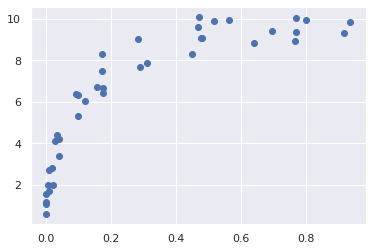

In [ ]:
plt.scatter(X,y);

Un modelo lineal simple utiliza una combinación lineal de las características de entrada para predecir  una salida

$$\hat y = w_0 + w_1 x_1 + \cdots + w_n x_n $$

Evaluemos un modelo de regresión lineal para estos datos





In [ ]:
cross_val_score(LinearRegression(), X, y).mean()

0.6235519510694914

Vemos que no se obtiene un muy buen resultado, lo cual es obvio ya que estamos tratando de ajustar un modelo lineal a unos datos que tienen una relación no lineal. Visualicemos el modelo construido

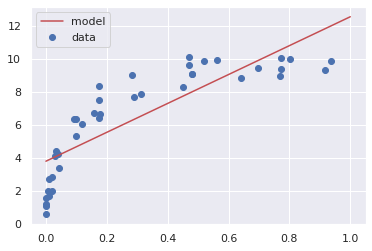

In [ ]:
model = LinearRegression().fit(X, y)

x_new = np.c_[np.linspace(0,1)]
y_pred = model.predict(x_new)

plt.scatter(X, y, label="data")
plt.plot(x_new, y_pred, "r-", label="model")
plt.legend();

Una opción que podemos intentar para mejorar el modelo es hacer que este sea más complejo. Una forma fácil de extender el modelo lineal es incluir combinaciones de pares de características de entrada:

$$\hat y = w_0 + w_1 x_1 + \cdots w_n x_n + w_{11}x_1 x_1 + w_{12} x_1 x_2 + \cdots$$

Esto nos permite capturar interacciones entre las características. Con estas nuevas características se puede construir un modelo de **regresión polinomial**. 

En nuestro caso, tendríamos:

$$\hat y = w_0 + w_1 x_1 + w_2 x_1^2$$

De esta manera podemos adaptar la regresión lineal a relaciones no lineales entre las variables. Observe que este sigue siendo un modelo lineal: la linealidad se refiere al hecho de que los coeficientes nunca se multiplican ni se dividen entre sí. 

Lo que hemos hecho con esta transformación es basicamente ir a una dimensión superior, donde un ajuste lineal sea capaz de captar relaciones más complicadas de los datos y luego proyectar el resultado sobre el espacio original.

Podemos generar esta interacción de características utilizando el transformador `PolynomialFeatures` de Sklearn:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)

Transformemos nuestra característica:

In [ ]:
X_poly = poly.fit_transform(X)

In [ ]:
# antes de la transformacion (X)
X[:5]

array([[1.73907352e-01],
       [5.18867376e-01],
       [1.30815988e-08],
       [9.14049845e-02],
       [2.15372915e-02]])

In [ ]:
# despues de la transformacion (X, X^2)
X_poly[:5]

array([[1.73907352e-01, 3.02437672e-02],
       [5.18867376e-01, 2.69223354e-01],
       [1.30815988e-08, 1.71128228e-16],
       [9.14049845e-02, 8.35487119e-03],
       [2.15372915e-02, 4.63854925e-04]])

**Ejercicio 1:** Defina una función `polyreg` que tome como argumento el grado del polinomio y que retorne un pipeline que encadene la transformación polinomial, la estandarización de las características y la construcción de un modelo de regresión lineal. Evalúe el modelo final con una validación cruzada.

In [ ]:
def polyreg(degree=2):
  """retorna un modelo de regresion polinomial"""
  return make_pipeline(PolynomialFeatures(degree),
                       StandardScaler(),
                       LinearRegression())

In [ ]:
cross_val_score(polyreg(), X, y).mean()

0.8561343998157547

**Ejercicio 2:** Defina una función `plot_polyreg` que permita visualizar la regresión polinomial en función del grado del polinomio

In [ ]:
def plot_polyreg(X, y, degree):
  """grafica un modelo de regresion polinomial"""

  model = polyreg(degree).fit(X, y)

  x = np.c_[np.linspace(X.min(),X.max(),100)]
  y_pred = model.predict(x)

  fig = plt.figure(figsize=(10,7))
  plt.scatter(X, y, label="data")
  plt.plot(x, y_pred, "r", label="model")
  plt.title(f"degree: {degree}")
  plt.legend();

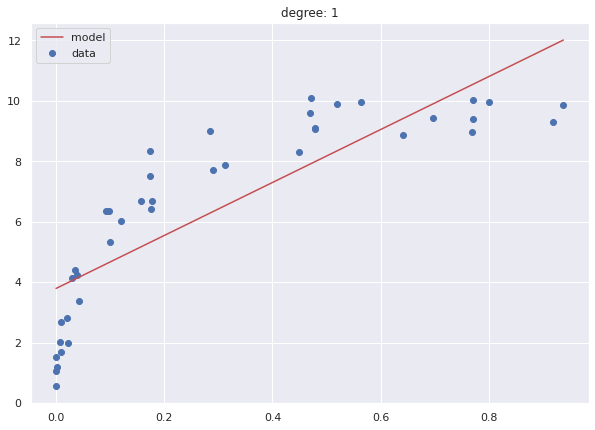

In [ ]:
plot_polyreg(X, y, 1)

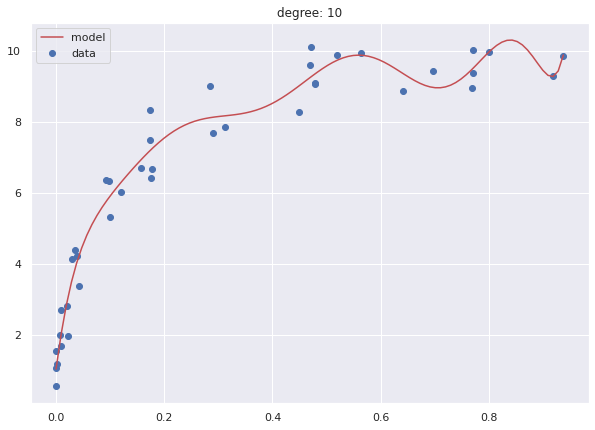

In [ ]:
plot_polyreg(X, y, 10)